In [21]:
library(forecast)
library(car)
library(ggplot2)
#library(zoo)
library(scales)
library(repr)

options(scipen=999)

# Change plot size to 10 x 6
options(repr.plot.width=8, repr.plot.height=5)

jp_data <- read.csv2("japan_employment.csv")
#Remove last row, 2015-01
jp_data <- jp_data[1:nrow(jp_data) - 1,]
jp_data$Date <- as.Date(jp_data$Date, format = "%Y-%m-%d")
#Create column with month value
jp_data$Month <- sapply(jp_data$Date, function(x) {format(as.Date(x), "%m")})
#jp_observed_ts <- zoo(jp_data)

head(jp_data)

,Date,Value,Month
1,2002-01-01,67.70215,01
2,2002-02-01,67.55654,02
3,2002-03-01,67.91463,03
4,2002-04-01,68.32146,04
5,2002-05-01,68.32711,05
6,2002-06-01,68.58675,06



Forecast method: Holt-Winters' additive method

Model Information:
Holt-Winters' additive method 

Call:
 hw(x = jp_ts, h = 12, seasonal = "additive", alpha = 0.75, beta = 0.1,  

 Call:
     gamma = 0.2) 

  Smoothing parameters:
    alpha = 0.75 
    beta  = 0.1 
    gamma = 0.2 

  Initial states:
    l = 68.4016 
    b = 0.0569 
    s=0.0091 0.1785 0.2011 0.1992 0.3099 0.2494
           0.3239 0.3637 0.1266 -0.4793 -0.8045 -0.6775

  sigma:  0.2242

     AIC     AICc      BIC 
347.2557 349.8191 386.9039 

Error measures:
                     ME      RMSE       MAE        MPE      MAPE      MASE
Training set 0.00256355 0.2241898 0.1758736 0.00331325 0.2499544 0.2931069
                  ACF1
Training set 0.1604779

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2015       72.81209 72.52478 73.09940 72.37269 73.25149
Feb 2015       72.87179 72.47550 73.26808 72.26571 73.47786
Mar 2015       72.91641 72.41835 73.41446 72.15470 73.67811
Apr 2015       73.61

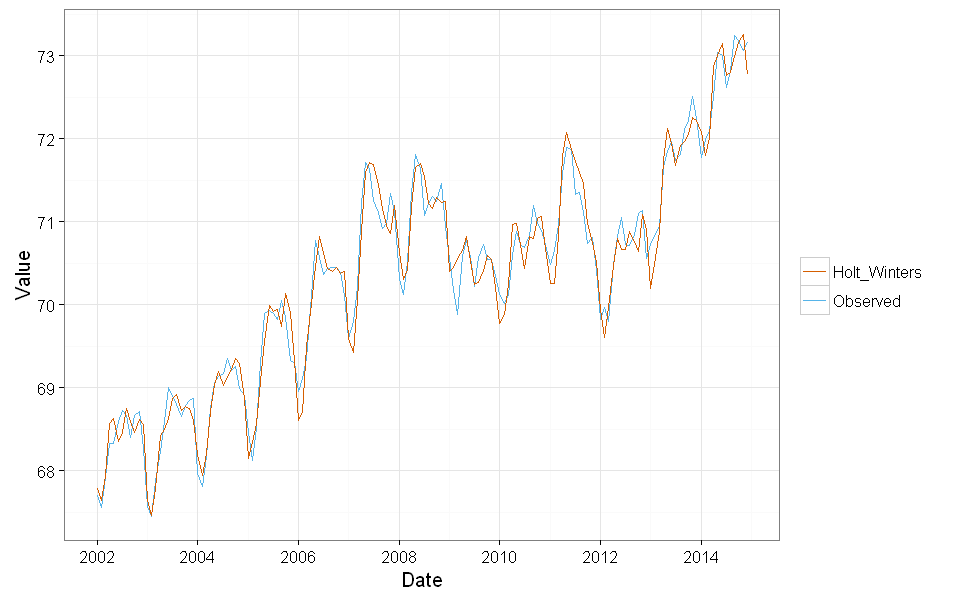

In [27]:
jp_ts <- ts(jp_data$Value, start= 2002, frequency=12)
hw_model <- hw(jp_ts, h = 12, seasonal = "additive", alpha = 0.75, beta = 0.1, gamma = 0.2)
summary(hw_model)
jp_data$HoltWinters_Fit <- hw_model$fitted
jp_data$Resiudals <- jp_data$Value - hw_model$fitted


ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = HoltWinters_Fit, color="Holt_Winters")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Holt_Winters="#D55E00")) +
    theme_bw()

[1] 1.660358

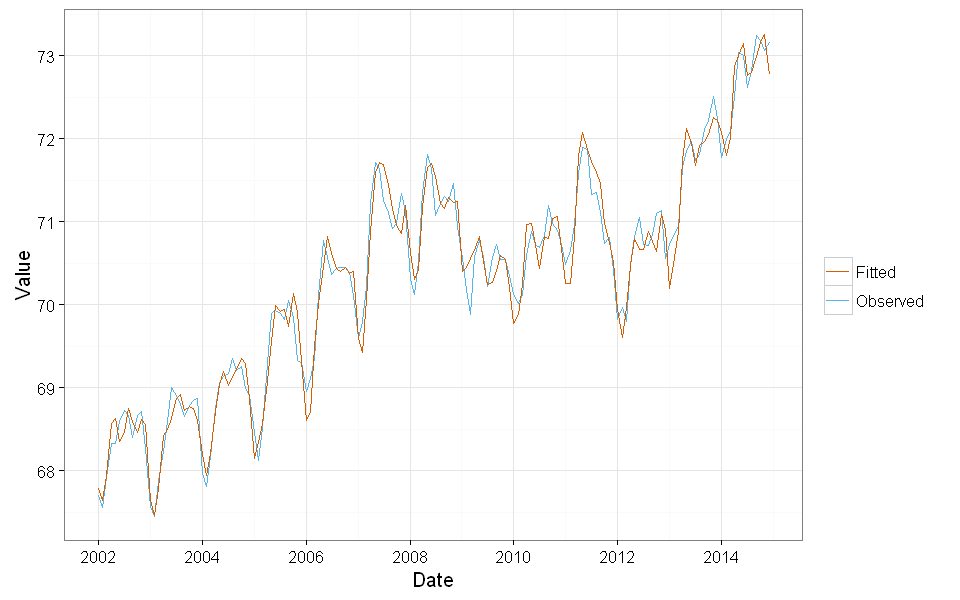

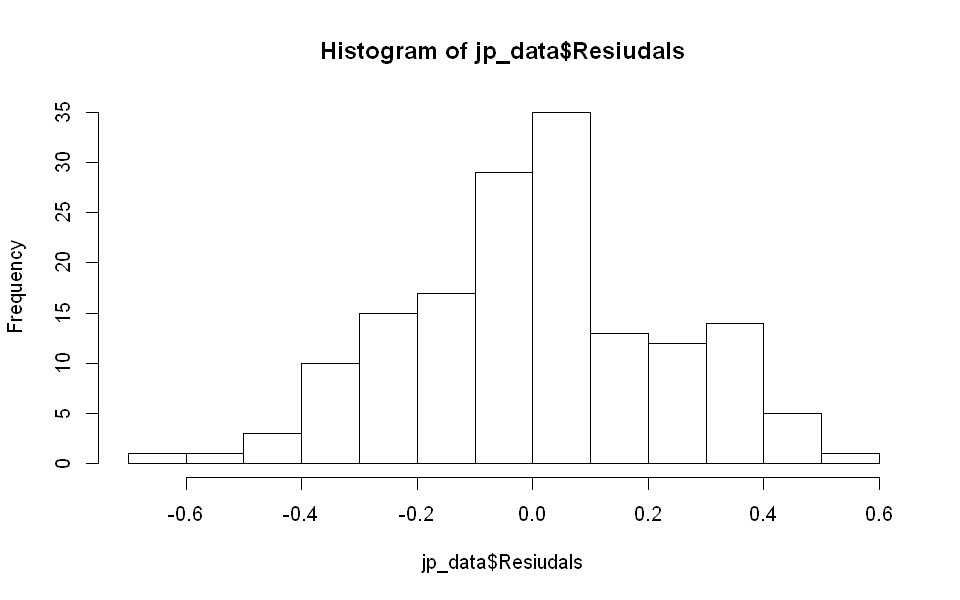

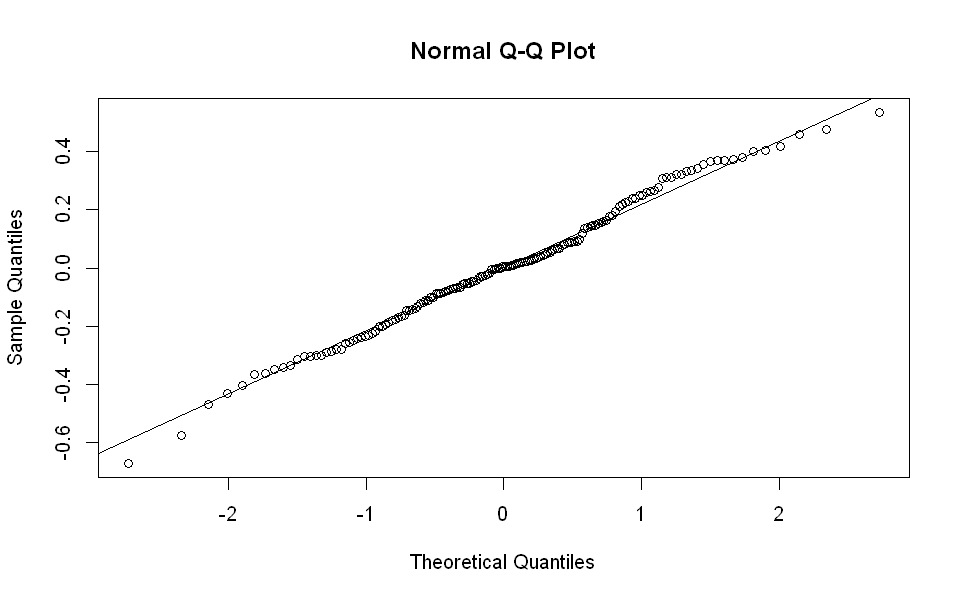

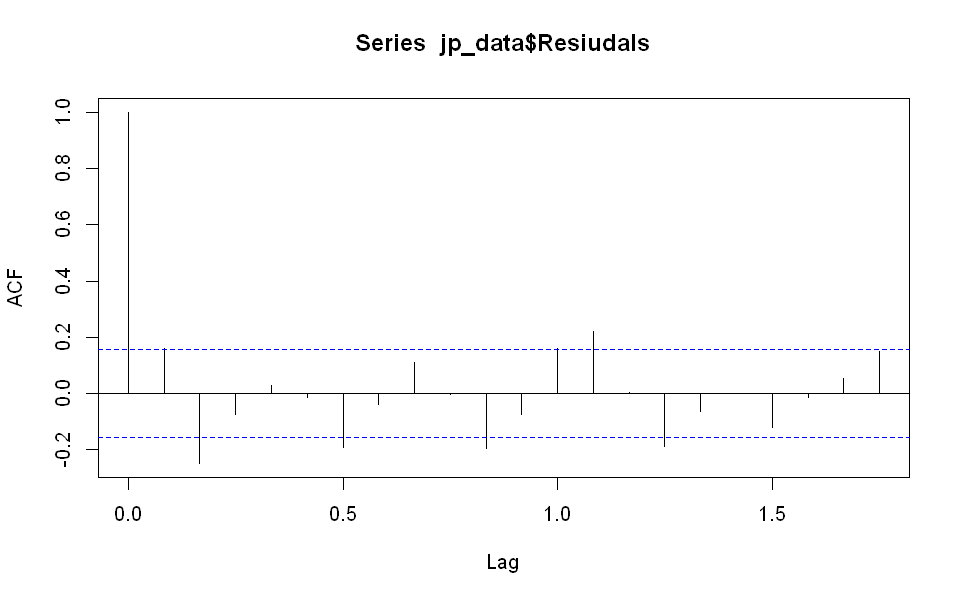

In [28]:
durbinWatsonTest(as.numeric(jp_data$Resiudals))


temp_data <- data.frame(Date = jp_data$Date, Value = jp_data$Value, Fitted = jp_data$HoltWinters_Fit)
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()

hist(jp_data$Resiudals)
qqnorm(jp_data$Resiudals)
qqline(jp_data$Resiudals)
acf(jp_data$Resiudals)

Warning message:
: Removed 12 rows containing missing values (geom_path).

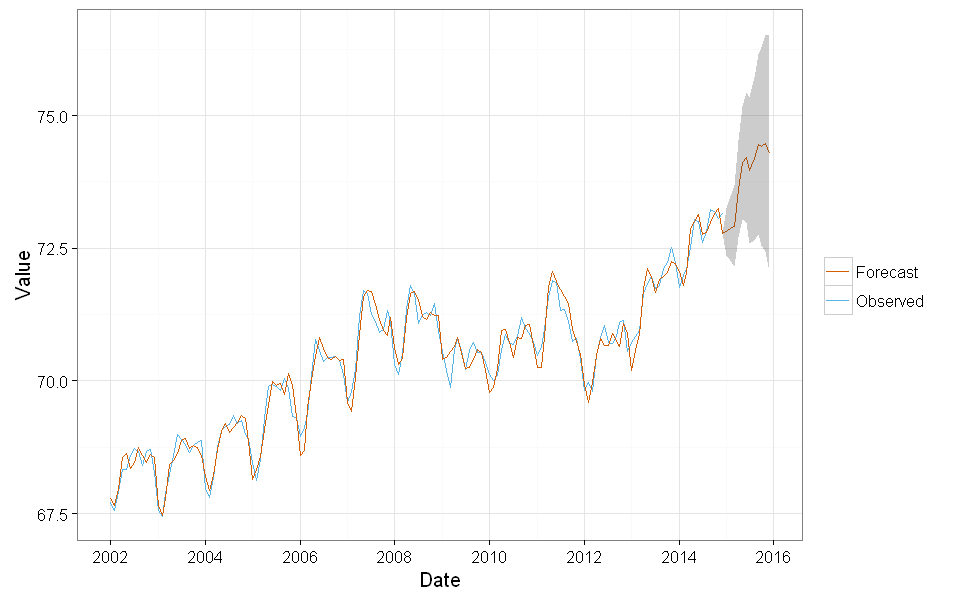

In [29]:
forecast_mean <- hw_model$mean
forecast_high <- hw_model$lower[,2]
forecast_low <- hw_model$upper[,2]

predict_data <- data.frame(Date = c(jp_data$Date, seq(as.Date("2015-01-01"), by = "month", length.out = 12)),
                        Value = c(jp_data$Value, rep(NA, 12)),
                        Forecast = c(jp_data$HoltWinters_Fit, forecast_mean),
                        Forecast_low = c(jp_data$HoltWinters_Fit, forecast_low),
                        Forecast_high = c(jp_data$HoltWinters_Fit, forecast_high))
#predict_data

ggplot(predict_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Forecast, color="Forecast")) +
    geom_ribbon(aes(x = Date, ymin=Forecast_low, ymax=Forecast_high), alpha=.25) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Forecast="#D55E00")) +
    theme_bw()

In [30]:
holt_winters_forecast <- data.frame(Date = seq(as.Date("2015-01-01"), by = "month", length.out = 12),
                           Low_95 = forecast_low,
                           Mean = forecast_mean,
                           High_95 = forecast_high)

holt_winters_forecast

,Date,Low_95,Mean,High_95
1,2015-01-01,73.25149,72.81209,72.37269
2,2015-02-01,73.47786,72.87179,72.26571
3,2015-03-01,73.67811,72.91641,72.1547
4,2015-04-01,74.52578,73.6117,72.69762
5,2015-05-01,75.1811,74.1147,73.04829
6,2015-06-01,75.42914,74.20886,72.98857
7,2015-07-01,75.34524,73.96864,72.59203
8,2015-08-01,75.72755,74.19168,72.65581
9,2015-09-01,76.16023,74.46183,72.76344
10,2015-10-01,76.28588,74.42152,72.55715
